In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import os
from PIL import Image

In [35]:
# Define the path to the directory containing the folders
base_path = '../Preprocessed Dataset'

# List the folders in the directory
folders = ['IBM Plex Sans Arabic', 'Lemonada', 'Marhey', 'Scheherazade New']

# Create a dictionary to hold the labels for each folder
labels = {folder: i for i, folder in enumerate(folders)}

# Prepare a list to store the image data and labels
data = []

# Loop through each folder and each image within the folder
for folder in folders:
    folder_path = os.path.join(base_path, folder)
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpeg'):  # Correctly specify file type in comments and check
            image_path = os.path.join(folder_path, filename)
            try:
                # Load the image and convert to grayscale if not already
                with Image.open(image_path) as img:
                    if img.mode != 'L':
                        img = img.convert('L')
                    # Convert image data to array and binarize
                    image_data = np.array(img)
                    image_data = (image_data > 127).astype(np.uint8)  # Use uint8 for binary data
                    # Append the image data and label to the list
                    data.append((image_data, labels[folder]))

            except Exception as e:
                print(f"Failed to process {image_path}: {e}")

# Check what's in the data list
print(f"Total images loaded: {len(data)}")

Total images loaded: 3997


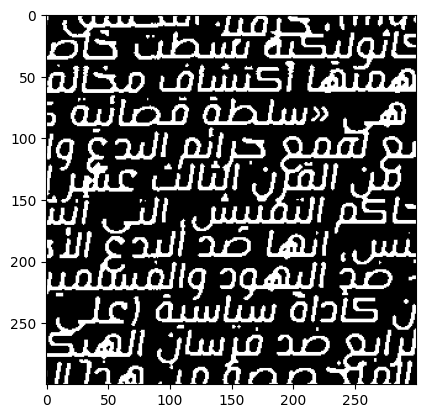

In [36]:
test_image = data[1013][0]
plt.imshow(test_image, cmap='gray')

In [37]:
def build_gabor_filters(orientations, frequencies, sigmas):
    filters = []
    for theta in orientations:
        for frequency, sigma in zip(frequencies, sigmas):
            lamda = 1 / frequency  # Wavelength
            gamma = 0.5  # Spatial aspect ratio

            # Adjust the kernel size based on the new sigma
            kernel_size = int(8 * sigma) if int(8 * sigma) % 2 == 1 else int(8 * sigma) + 1  # Ensure kernel size is odd
            zero_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, 0, ktype=cv2.CV_32F)
            neg_kernel = cv2.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, -np.pi/2, ktype=cv2.CV_32F)
            filters.append([zero_kernel, neg_kernel])
    return filters


def apply_gabor_filters(image, filters):
    responses = np.zeros((len(filters), image.shape[0], image.shape[1]))
    for i, kernels in enumerate(filters):
        zero_kernel, neg_kernel = kernels[0], kernels[1]
        zero_filtered = cv2.filter2D(image, cv2.CV_8U, zero_kernel)  # Corrected data type for single-channel image
        neg_filtered = cv2.filter2D(image, cv2.CV_8U, neg_kernel)  # Corrected data type for single-channel image
        E = np.sqrt(zero_filtered ** 2 + neg_filtered ** 2)
        responses[i] = E
    return responses

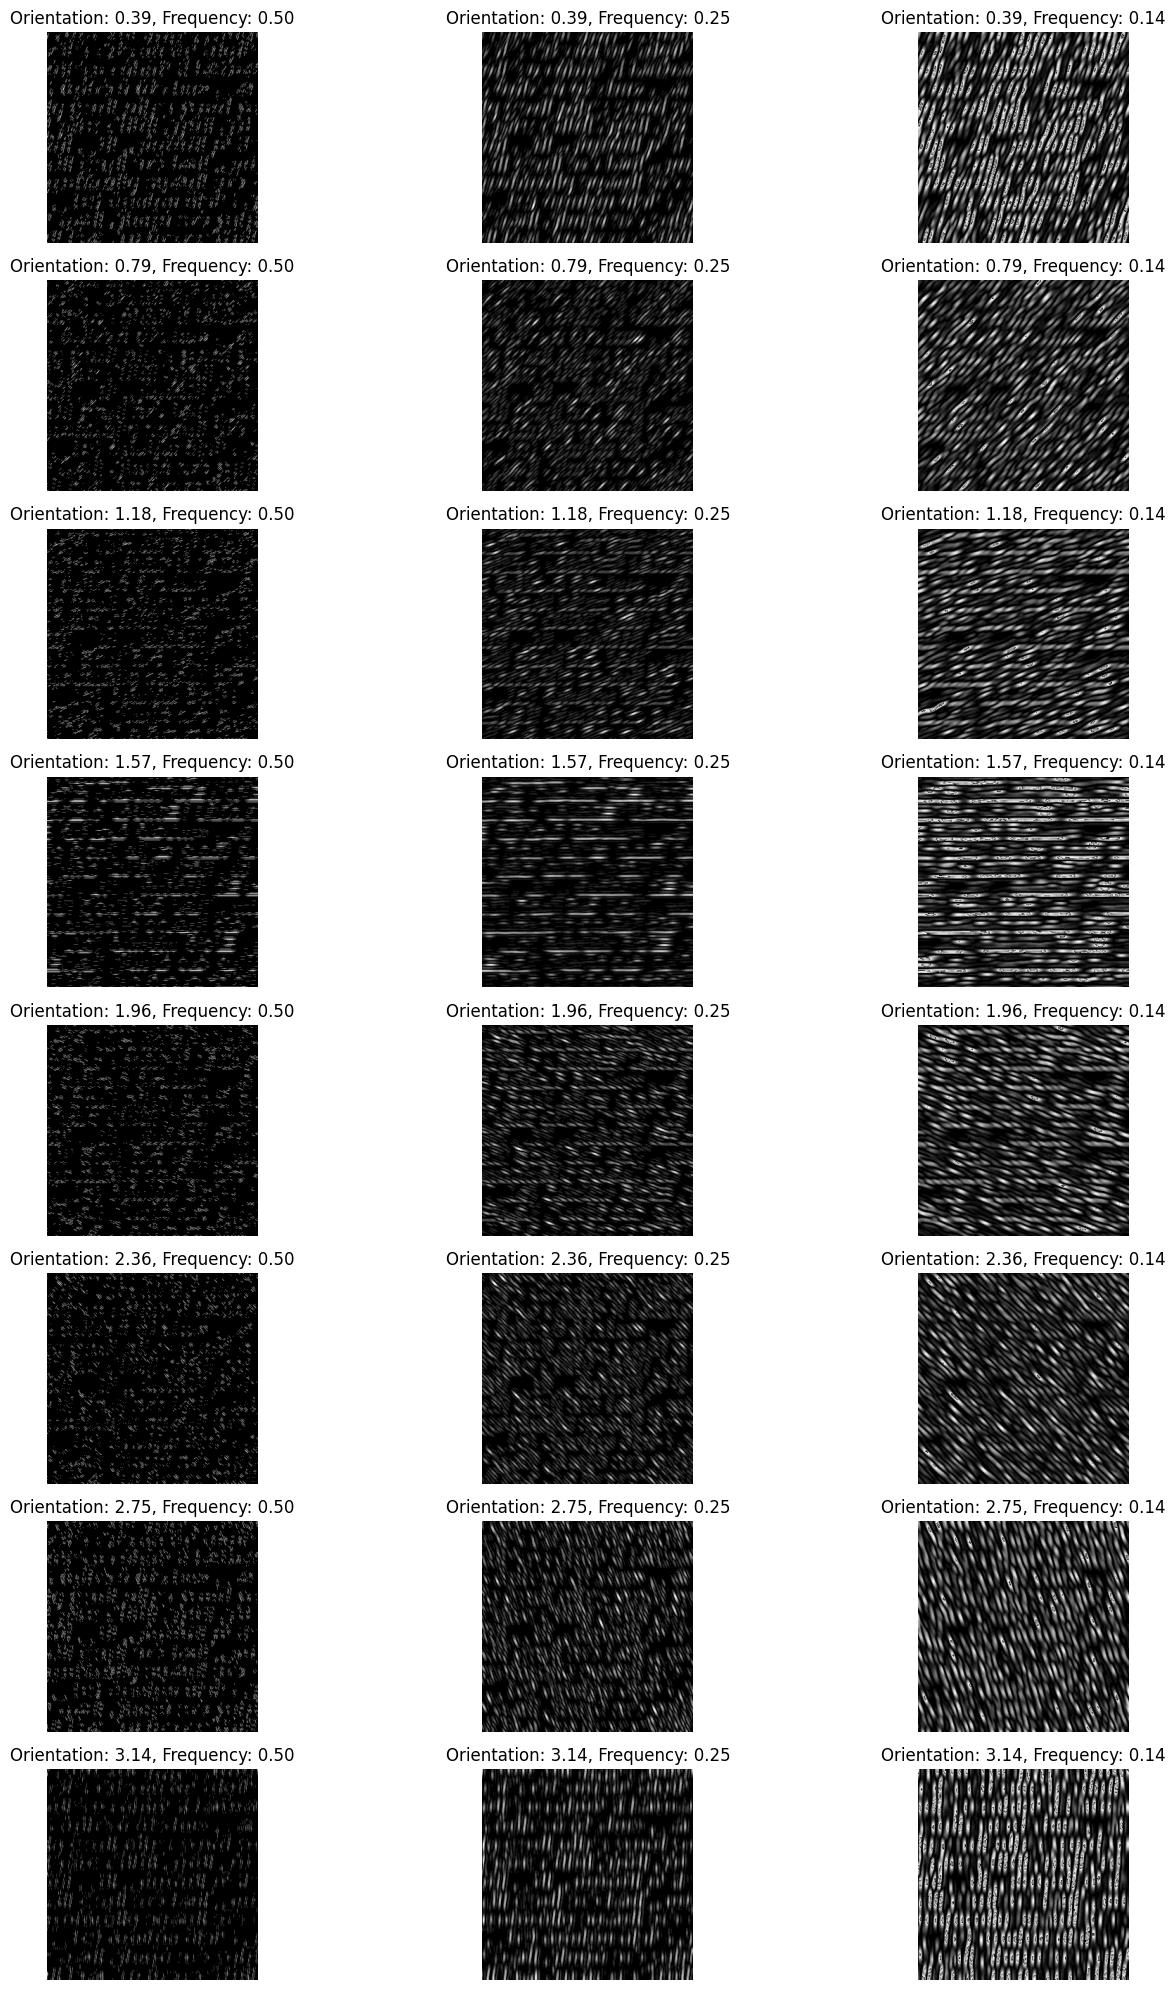

In [38]:
# Define parameters
orientations = [k * np.pi / 8 for k in range(1, 9)]
frequencies = [1/2, 1/4, 1/7]
sigmas = [1, 2, 3]  # Larger values compared to what might be typical for finer filters

# Generate and apply Gabor filters
gabor_filters = build_gabor_filters(orientations, frequencies, sigmas)
gabor_responses = apply_gabor_filters(test_image, gabor_filters)

# Plotting the results
fig, ax = plt.subplots(8, 3, figsize=(15, 20))
for i, response in enumerate(gabor_responses):
    ax[i // 3, i % 3].imshow(response, cmap='gray')
    ax[i // 3, i % 3].set_title(f"Orientation: {orientations[i//3]:.2f}, Frequency: {frequencies[i%3]:.2f}")
    ax[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()

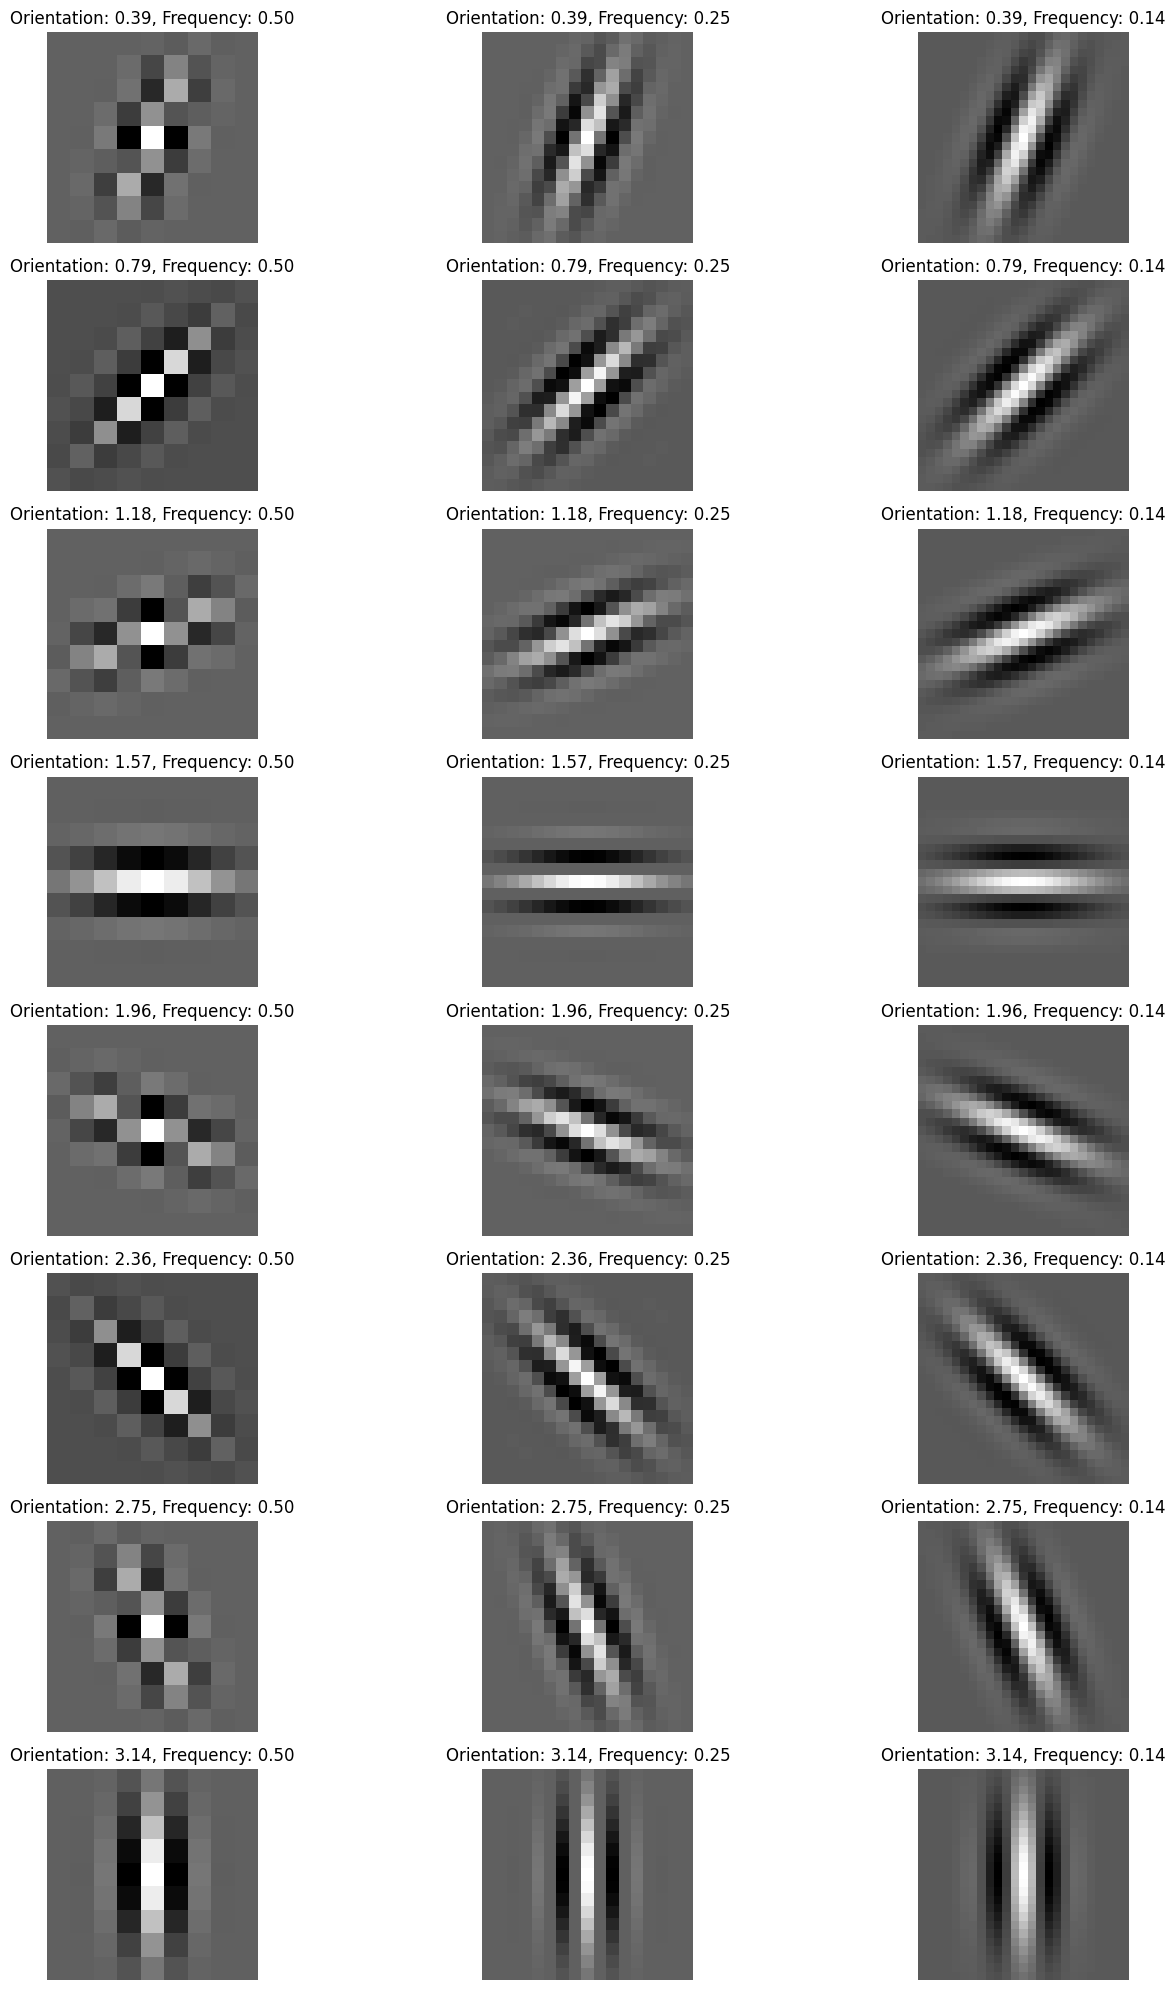

In [39]:
fig, ax = plt.subplots(8, 3, figsize=(15, 20))
for i, filter in enumerate(gabor_filters):
    zero_kernel, neg_kernel = filter[0], filter[1]
    ax[i // 3, i % 3].imshow(zero_kernel, cmap='gray')
    ax[i // 3, i % 3].set_title(f"Orientation: {orientations[i//3]:.2f}, Frequency: {frequencies[i%3]:.2f}")
    ax[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

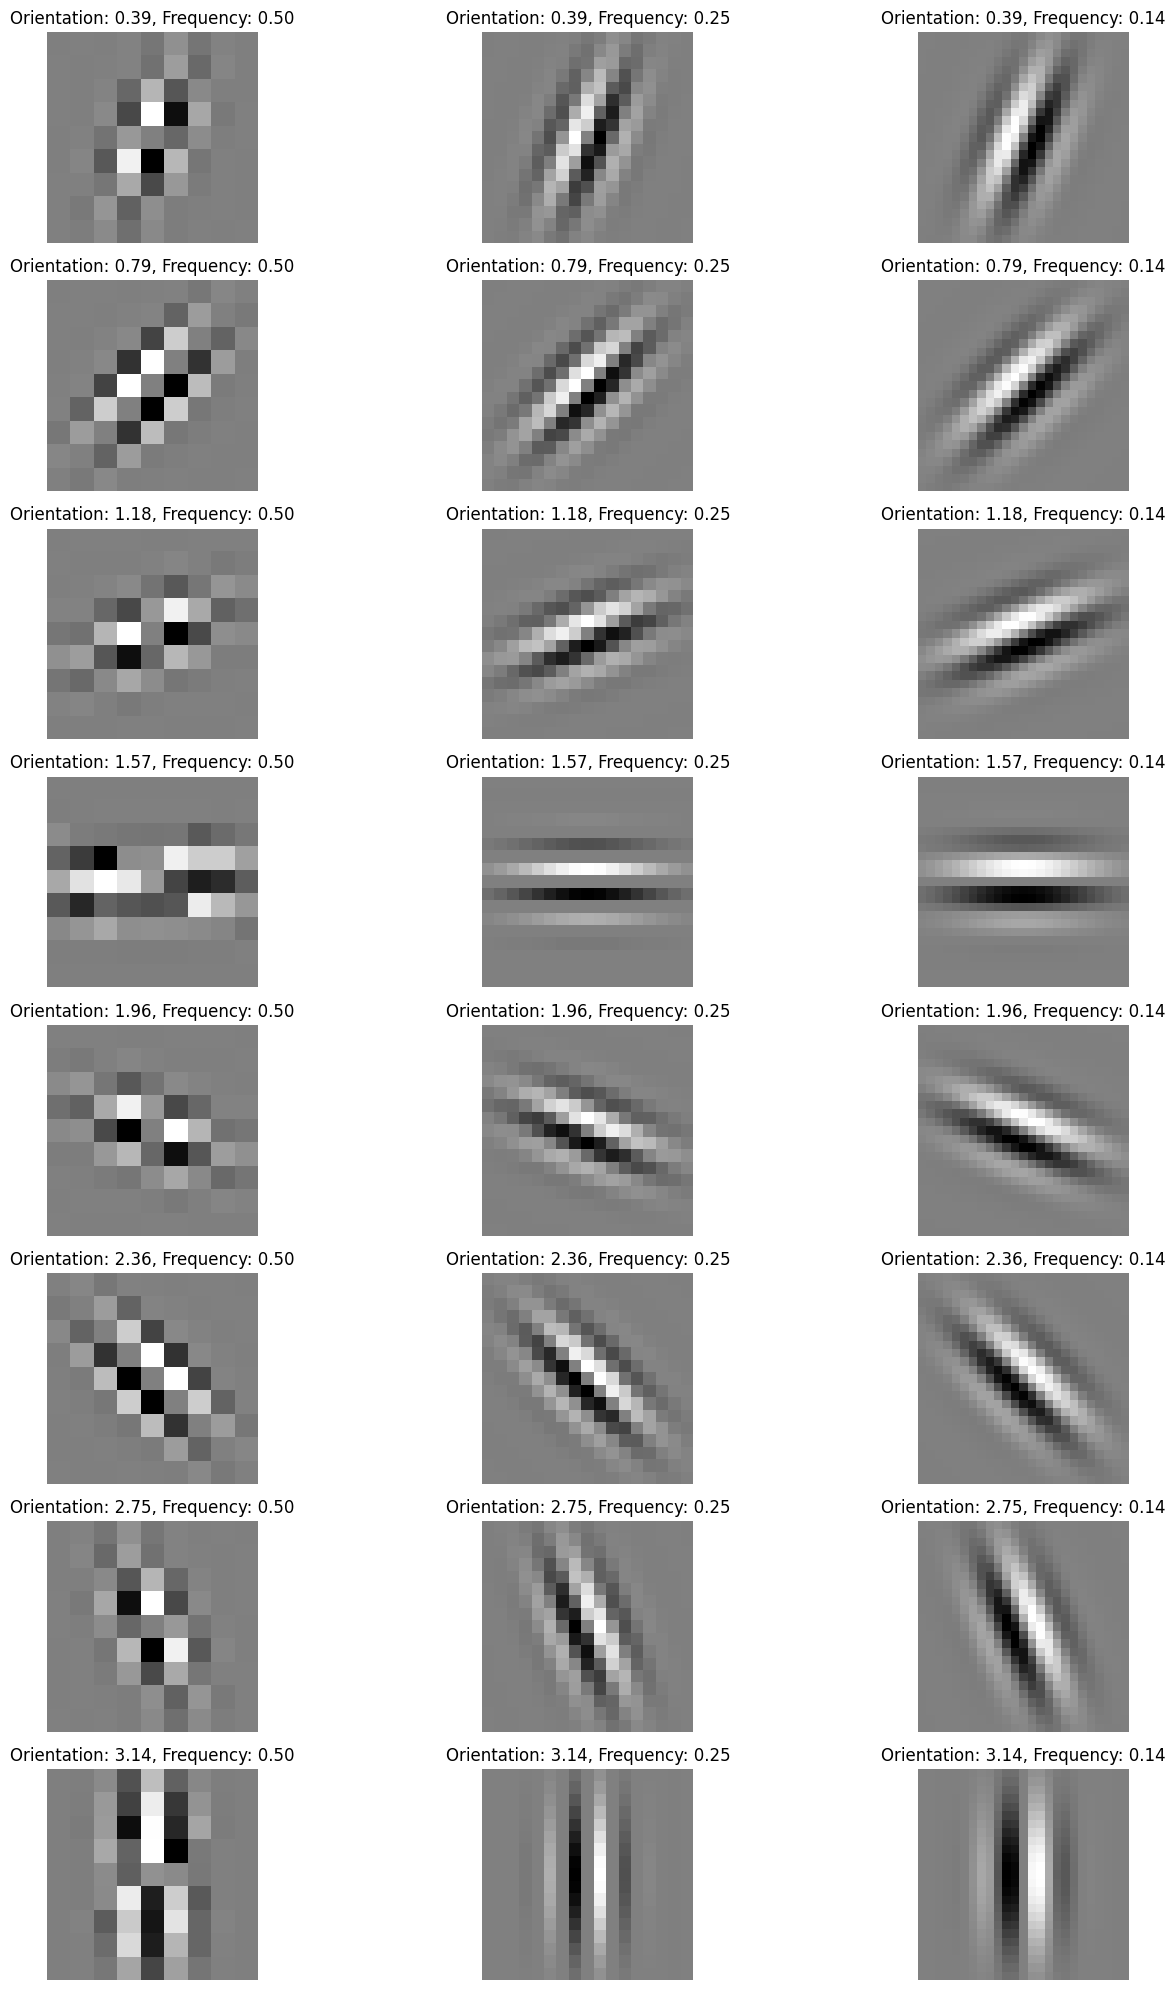

In [40]:
fig, ax = plt.subplots(8, 3, figsize=(15, 20))
for i, filter in enumerate(gabor_filters):
    zero_kernel, neg_kernel = filter[0], filter[1]
    ax[i // 3, i % 3].imshow(neg_kernel, cmap='gray')
    ax[i // 3, i % 3].set_title(f"Orientation: {orientations[i//3]:.2f}, Frequency: {frequencies[i%3]:.2f}")
    ax[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [45]:
gabor_responses.shape

(24, 300, 300)

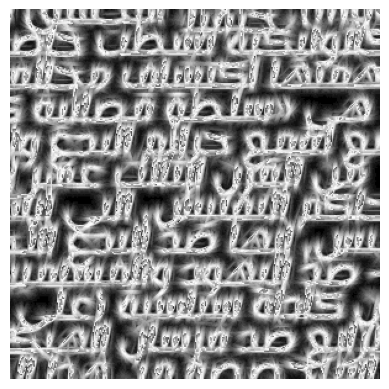

In [46]:
max_image = np.max(gabor_responses, axis=0)
plt.imshow(max_image, cmap='gray')
plt.axis('off')
plt.show()

In [53]:
def extract_features(gabor_responses):
    features = [] 
    # compute max image (per pixel) across all orientations and frequencies
    for i, response in enumerate(gabor_responses):
        # Calculate the mean and standard deviation of the response
        features.append(np.mean(response))
        features.append(np.std(response))
    
    max_image = np.max(gabor_responses, axis=0)
    features.append(np.mean(max_image))
    features.append(np.std(max_image))  

    return np.array(features)

In [54]:
features = extract_features(gabor_responses)
features.shape

(50,)

In [55]:
from sklearn.model_selection import train_test_split
# Assuming 'data' is the list that contains all your images and their labels
# Separate data into two lists: features and labels
data, labels = zip(*data)

# Convert these lists to numpy arrays for compatibility with sklearn
data = np.array(data)
labels = np.array(labels)

# Split the data using sklearn's train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
data = 1
labels = 1

# Check the size of the training and test sets
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 3197
Test set size: 800


In [56]:
# extract features for all images in the training set
X_train_features = np.array([extract_features(apply_gabor_filters(image, gabor_filters)) for image in X_train])

In [59]:
X_test_features = np.array([extract_features(apply_gabor_filters(image, gabor_filters)) for image in X_test])

In [60]:
print(X_train_features.shape)
print(X_test_features.shape)

(3197, 50)
(800, 50)


In [61]:
from sklearn import svm

# Create a SVM classifier
clf = svm.SVC()

# Train the model using the training sets
clf.fit(X_train_features, y_train)

In [63]:
y_pred = clf.predict(X_train_features)
np.mean(y_pred == y_train)

0.856427901157335

In [64]:
# Predict the response for test dataset
y_pred = clf.predict(X_test_features)
print(np.mean(y_pred == y_test))

0.85125
